In [1]:
import os

os.environ["LIBROSA_CACHE_DIR"] = "/tmp/librosa"
os.environ["LIBROSA_CACHE_LEVEL"] = "50"

In [2]:
from multiprocessing import Pool, cpu_count

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
from tensorflow import keras
from tqdm import tqdm

from lib.utils import fix_random_seed, read_json
from src.config import c
from src.data_utils import (
    boost_multiple_occurences,
    geofilter_predictions,
    normalize_soundscapes_df,
    predictions_to_text_labels,
    read_soundscapes_info,
)
from src.generator import Generator
from src.geo_filter import filters as geo_filters
from src.models import Div, SinCos, YMToDate
from src.services import get_msg_provider, get_wave_provider

In [3]:
N_MELS = TIME_STEPS = 256
POWER = 2
DEVICE = "cpu"
N_FFT = 2048

In [4]:
wave_p = get_wave_provider(c)
c["MSG_DEVICE"] = DEVICE
c["MSG_N_FFT"] = N_FFT
msg_p = get_msg_provider(c)

In [5]:
x = wave_p.get_audio_fragment("XC11209.ogg", [0, 5])

In [6]:
ipd.Audio(data=x, rate=c["AUDIO_SR"])

In [7]:
for i in tqdm(range(10000)):
    msg = msg_p.msg(x, n_mels=N_MELS, time_steps=TIME_STEPS, power=POWER)

 41%|████      | 4091/10000 [00:06<00:08, 657.50it/s]


KeyboardInterrupt: 

In [ ]:
plt.imshow(msg)

In [ ]:
def power_to_db(magnitude, ref=1.0, amin=1e-10, top_db=80.0):
    log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref))
    log_spec = np.maximum(log_spec, log_spec.max() - top_db)
    return log_spec

In [ ]:
import librosa
import torch
from torchaudio.transforms import MelSpectrogram

t = MelSpectrogram(
    power=POWER,
    win_length=None,
    n_fft=c["MSG_N_FFT"],
    n_mels=N_MELS,
    sample_rate=32000,
    hop_length=32000 * 5 // (TIME_STEPS - 1),
    f_min=0,
    f_max=160000,
).to(DEVICE)

for i in tqdm(range(100)):
    key = f"{POWER:.1f}:{N_MELS:d}:{TIME_STEPS:d}"
    wave = torch.tensor(x.reshape([1, -1]).astype(np.float32)).to(DEVICE)
    msg = t(wave)[0].cpu().numpy()
#     msg = power_to_db(msg)
#     msg = librosa.power_to_db(msg)

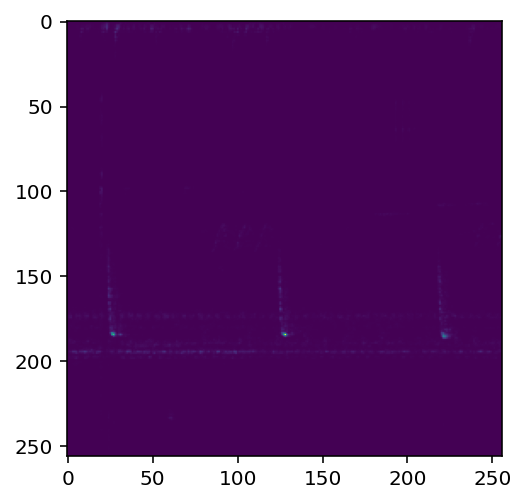

In [46]:
plt.imshow(msg)

In [47]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K


class PowerToDb(keras.layers.Layer):
    def __init__(self, ref=1.0, amin=1e-10, top_db=80, **kwargs):
        super(PowerToDb, self).__init__(**kwargs)
        self._ref = ref
        self._amin = amin
        self._top_db = top_db

    def call(self, inputs):
        # see https://github.com/librosa/librosa/blob/0eada806c170e061eed866fc180ef489bf36b5e5/librosa/core/spectrum.py#L1447

        log10 = 2.302585092994046
        
        inputs = K.cast(inputs, 'float32')

        log_spec = (
            10.0 * K.log(K.clip(inputs, min_value=self._amin, max_value=None)) / log10
        )

        log_spec -= 10.0 * K.log(K.max([self._amin, self._ref])) / log10

        log_spec = K.clip(
            log_spec, min_value=K.max(log_spec) - self._top_db, max_value=None
        )

        return log_spec

    def get_config(self):
        return {
            "ref": self._ref,
            "amin": self._amin,
            "top_db": self._top_db,
        }

In [48]:
from lib.utils import float2d_to_rgb

In [49]:
msg_rgb.shape

(256, 256, 3)

In [50]:
msg_rgb = float2d_to_rgb(msg)

In [51]:
i = keras.layers.Input(shape=msg_rgb.shape, dtype="float32")
x = PowerToDb()(i)
m = keras.models.Model(inputs=[i], outputs=[x])

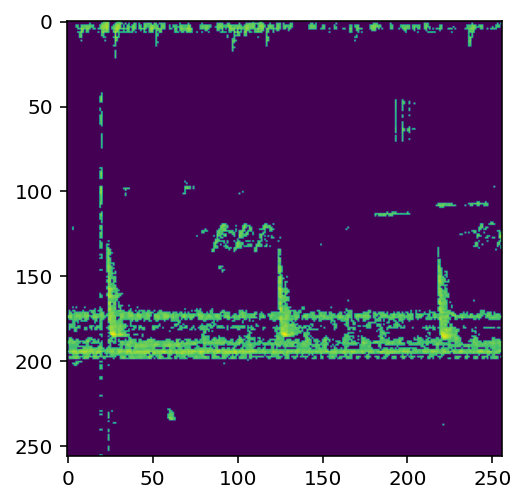

In [54]:
plt.imshow(m.predict(np.array(msg_rgb)[np.newaxis,...])[0].astype(np.))